In [1472]:
import pyvisa
import time
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np

In [1638]:
rm = pyvisa.ResourceManager()
print(rm.list_resources())

('USB0::0xF4EC::0x1103::SDG1XCAD2R3284::INSTR', 'ASRL1::INSTR', 'ASRL12::INSTR', 'ASRL16::INSTR')


In [1641]:
instr = rm.open_resource("ASRL12::INSTR")
instr.baud_rate = 115200
instr.end_input = pyvisa.constants.SerialTermination.none

In [ ]:
while True:
    for i in range(128):
        instr.write_raw(bytes(chr(i), encoding='ascii'))
        time.sleep(.05)
        read_byte = instr.read_bytes(1)
        read_i = int.from_bytes(read_byte, byteorder='big')
        if i != read_i:
            print(i, " != ", read_i)
            break

In [1422]:
try:
    while True:
        instr.read_bytes(1)
except pyvisa.VisaIOError:
    pass

In [1423]:
instr.close()

In [877]:
# AD9910 data direction
instr.write_raw('F')
instr.write_raw(bytes(bytearray([0])))

(1, <StatusCode.success: 0>)

In [1667]:
# proportional constant
instr.write_raw('P')
instr.write_raw(bytes(bytearray([255]))) # LSB
instr.write_raw(bytes(bytearray([0]))) # MSB

instr.write_raw('p')
instr.read_bytes(2)

b'\x00\xff'

In [1707]:
# integral constant
instr.write_raw('I')
instr.write_raw(bytes(bytearray([0]))) # LSB
instr.write_raw(bytes(bytearray([10]))) # MSB

instr.write_raw('i')
instr.read_bytes(2)

b'\n\x00'

In [1644]:
# setpoint
instr.write_raw('S')
instr.write_raw(bytes(bytearray([0xff]))) # LSB
instr.write_raw(bytes(bytearray([0x4f]))) # MSB

instr.write_raw('s')
instr.read_bytes(2)

b'O\xff'

In [1695]:
# measured data

instr.write_raw('d')
instr.read_bytes(2)

b'\x98z'

In [1646]:
def read_PID_output(output="accum."):
    # request data
    if output == "accum.":
        instr.write_raw('a')
    elif output == "error":
        instr.write_raw('e')
    elif output == "out":
        instr.write_raw('o')
    
    # read raw data
    raw_result = instr.read_bytes(4)
    
    # convert bytes to integer
    if output == "error":
        int_result = int.from_bytes(raw_result, byteorder='big', signed=True)
    else:
        int_result = int.from_bytes(raw_result, byteorder='big', signed=False)
    
    # return as percentage of largest 4-byte number
    return 100*int_result/4294967295

In [1651]:
for output in ["accum.", "error", "out"]:
    val = read_PID_output(output)
    print(output, "\t= ", round(val, 2), "%")

accum. 	=  46.86 %
error 	=  0.0 %
out 	=  12.15 %


In [1652]:
acc_arr, err_arr, out_arr = [], [], []
for i in tqdm(range(200)):
    acc_arr.append(read_PID_output("accum."))
    err_arr.append(read_PID_output("error"))
    out_arr.append(read_PID_output("out"))

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 91.88it/s]


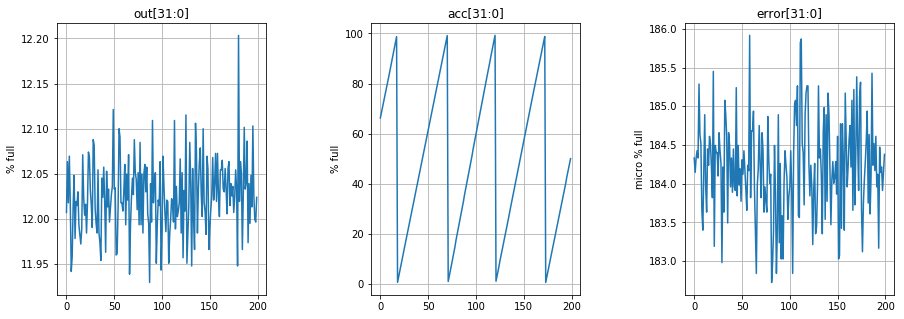

In [1666]:
# format
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,5))
for ax in [ax1, ax2, ax3]:
    ax.grid()
plt.subplots_adjust(wspace=.5)

# labels
ax1.set_title("out[31:0]")
ax1.set_ylabel("% full")
ax2.set_title("acc[31:0]")
ax2.set_ylabel("% full")
ax3.set_title("error[31:0]")
ax3.set_ylabel("micro % full")

# data
ax1.plot(out_arr)
ax2.plot(acc_arr)
ax3.plot(1000000*np.array(err_arr))

In [1622]:
siglent = rm.open_resource('USB0::0xF4EC::0x1103::SDG1XCAD2R3284::INSTR')
print(siglent.query('*IDN?'))

def set_frequency(freq):
    siglent.write("C1:BSWV FRQ,"+str(freq))

Siglent Technologies,SDG1032X,SDG1XCAD2R3284,1.01.01.30R1



In [1657]:
set_frequency(50*1000)

In [1661]:
scope = rm.open_resource('USB0::0x1AB1::0x04CE::DS1ZA203916635::INSTR')
print(scope.query('*IDN?'))

def read_scope(item="VAVG", ch="CHAN1"):
    # obtain measurement
    try:
        val = scope.query(":MEAS:ITEM? "+item+","+ch)
    except pyvisa.VisaIOError:
        return np.nan
    
    # convert to number
    try:
        return float(val[:-1])
    except ValueError:
        return np.nan

RIGOL TECHNOLOGIES,DS1054Z,DS1ZA203916635,00.04.04.SP3



In [1665]:
read_scope("VAVG", "CHAN1")
read_scope("VRMS", "CHAN1")

0.6511495

In [1689]:
def set_setpoint(setpoint_MSB, setpoint_LSB=0, read_result=False):
    # setpoint
    instr.write_raw('S')
    instr.write_raw(bytes(bytearray([setpoint_LSB]))) # LSB
    instr.write_raw(bytes(bytearray([setpoint_MSB]))) # MSB
    
    if read_result:
        instr.write_raw('s')
        return instr.read_bytes(2)

In [1717]:
setpoint_arr, volts_arr = [], []

for i in tqdm(range(1,185)):
    setpoint_arr.append(i)
    set_setpoint(i)
    time.sleep(0.2)
    volts_arr.append(read_scope("VAVG", "CHAN1"))

100%|████████████████████████████████████████████████████████████████████████████████| 184/184 [00:38<00:00,  4.78it/s]


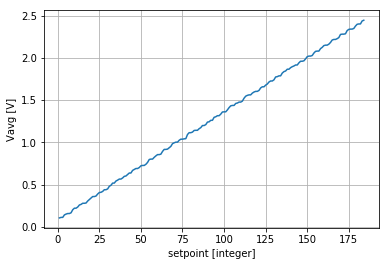

In [1718]:
# format
plt.grid()

#labels
plt.xlabel("setpoint [integer]")
plt.ylabel("Vavg [V]")

# data
plt.plot(setpoint_arr, volts_arr)